In [1]:
import sys
import os
codebase = '../'
sys.path.append(codebase)

In [2]:
import numpy as np
import tensorflow as tf

In [3]:
from model import VRNNCell, VRNN_model
from data import get_stock_data
from sampler import create_train_test_dataset
from transformation import fhn, linear, lorenz
from distribution import dirac_delta, mvn
from trainer import trainer
from result_saving import create_RLT_DIR
from result_saving import plot_training, plot_training_2d
from result_saving import plot_loss_MSE
from result_saving import plot_hidden, plot_expression

D:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
D:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
D:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
D:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
D:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
D:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, fa

First, define some hyperparameters and create the folder to store results

In [4]:
time = 100                    # num of time steps
n_particles = 1               # when == 1 use VAE, when > 1 use Importance Weight AutoEncoder
batch_size = 16

lr = 1e-4
epoch = 100

n_train = 50 * batch_size
n_test = 1 * batch_size

Dx = 2                        # dimension of the observation
Dz = 2                        # dimension of the hidden states
Dh = 100                      # dimension of the LSTM state used in VRNN

initial_state_all_zero = True # whether the LSTM state used in VRNN use zero_state as initial state

rslt_dir_name = "fhn"

experiment_params = {"time": time,
                     "n_particles": n_particles,
                     "batch_size": batch_size,
                     "lr": lr,
                     "epoch": epoch,
                     "initial_state_all_zero": initial_state_all_zero,
                     "rslt_dir_name": rslt_dir_name}
RLT_DIR = create_RLT_DIR(experiment_params)

Then generate the data set for training with simulation.
<br>
In the simulation, the transition function $f$ is deterministic [FitzHugh–Nagumo model](https://en.wikipedia.org/wiki/FitzHugh%E2%80%93Nagumo_model), the emission function $g$ is some linear transformation with gaussian noise, and the initial states are sampled from $\text{Uniform}(-3,3)$.

In [5]:
# transition function
fhn_params = (1.0, 0.95, 0.05, 1.0, 0.15)
f_sample_tran = fhn.fhn_transformation(fhn_params)
f_sample_dist = dirac_delta.dirac_delta(f_sample_tran)

# emission function
linear_params = np.array([[0, 1]])
g_sample_tran = linear.linear_transformation(linear_params)
mvn_sigma = 0.2 * np.eye(1)
g_sample_dist = mvn.mvn(g_sample_tran, mvn_sigma)

# create data set
dataset = create_train_test_dataset(
    n_train=n_train,
    n_test=n_test,
    time=time,
    Dz=Dz,
    Dx=Dx,
    f=f_sample_dist,
    g=g_sample_dist,
    z_0=None,
    lb=-3,
    ub=3)
hidden_train, obs_train, hidden_test, obs_test = dataset

In [6]:
myVRNNCell = VRNNCell(Dx=Dx,
                      Dh=Dh,
                      Dz=Dz,
                      batch_size=batch_size,
                      n_particles=n_particles,
                      x_ft_Dhs=[100],
                      z_ft_Dhs=[100],
                      prior_Dhs=[100],
                      enc_Dhs=[100],
                      dec_Dhs=[100])
model = VRNN_model(myVRNNCell,
                   initial_state_all_zero=initial_state_all_zero,
                   is_lstm_Dh=50,
                   sigma_min=1e-3)

In [7]:
mytrainer = trainer(model)
mytrainer.set_result_saving(RLT_DIR, save_freq=10, saving_num=batch_size)
mytrainer.set_data_set(hidden_train, obs_train, hidden_test, obs_test)

In [8]:
metrics, hidden_val, prediction_val = mytrainer.train(lr=lr,
                                                      epoch=epoch,
                                                      print_freq=5)
loss_trains, loss_tests, MSE_trains, MSE_tests = metrics
hidden_val_train, hidden_val_test = hidden_val
prediction_val_train, prediction_val_test = prediction_val

iter    0, train loss: -4.659, test loss: -4.763, train MSE:  2.943, test MSE:  3.053
iter    5, train loss: -1.521, test loss: -1.553, train MSE:  0.250, test MSE:  0.260
iter   10, train loss: -1.327, test loss: -1.356, train MSE:  0.220, test MSE:  0.226
iter   15, train loss: -1.298, test loss: -1.326, train MSE:  0.215, test MSE:  0.220
iter   20, train loss: -1.278, test loss: -1.315, train MSE:  0.210, test MSE:  0.217
iter   25, train loss: -1.271, test loss: -1.304, train MSE:  0.209, test MSE:  0.215
iter   30, train loss: -1.255, test loss: -1.284, train MSE:  0.205, test MSE:  0.212
iter   35, train loss: -1.251, test loss: -1.289, train MSE:  0.204, test MSE:  0.212
iter   40, train loss: -1.245, test loss: -1.285, train MSE:  0.203, test MSE:  0.210
iter   45, train loss: -1.257, test loss: -1.291, train MSE:  0.205, test MSE:  0.212
iter   50, train loss: -1.240, test loss: -1.273, train MSE:  0.202, test MSE:  0.209
iter   55, train loss: -1.239, test loss: -1.273, trai

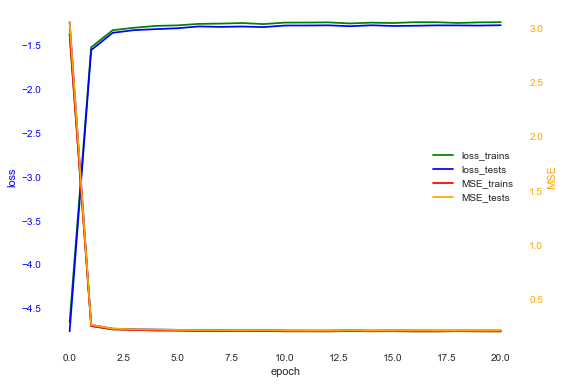

In [9]:
plot_loss_MSE(RLT_DIR, loss_trains, loss_tests, MSE_trains, MSE_tests, show=True)

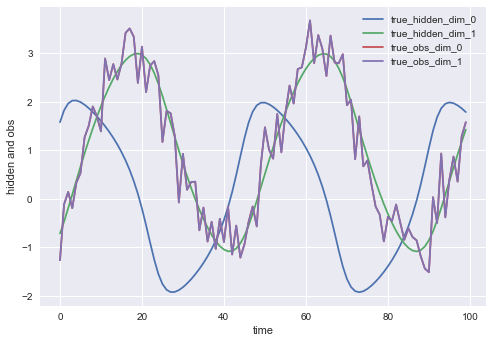

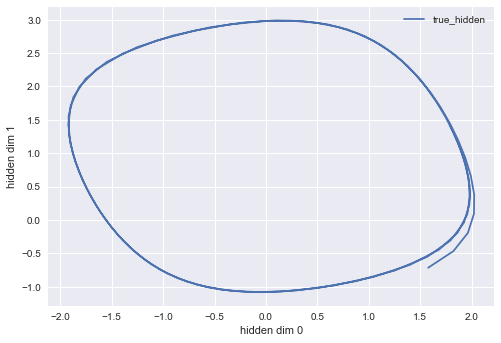

In [10]:
plot_training(RLT_DIR,
              hidden_test[0:1],
              obs_test[0:1],
              is_test=True,
              show=True)
plot_training_2d(RLT_DIR,
                 hidden_test[0:1],
                 is_test=True,
                 show=True)

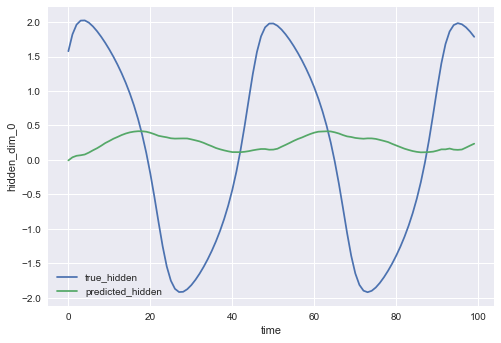

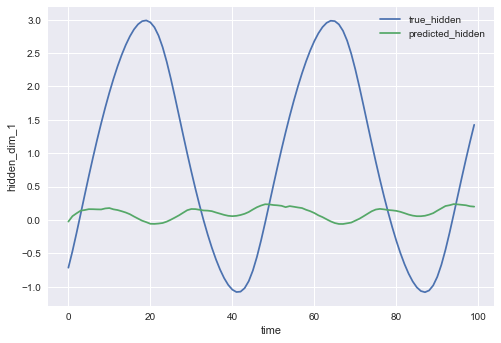

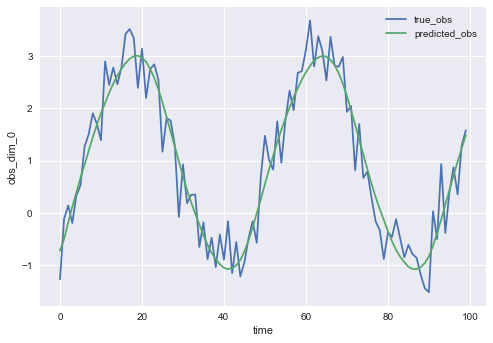

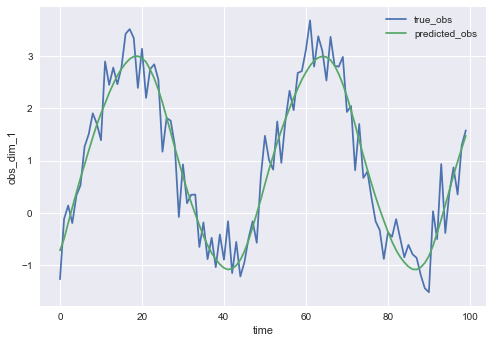

In [11]:
plot_hidden(RLT_DIR, 
            np.mean(hidden_val_test, axis=2)[0:1],
            hidden_test[0:1],
            is_test=True,
            show=True)
plot_expression(RLT_DIR,
                np.mean(prediction_val_test, axis=2)[0:1],
                obs_test[0:1],
                is_test=True,
                show=True)

In [ ]:
import sys
import os
codebase = '../'
sys.path.append(codebase)

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
from model import VRNNCell, VRNN_model
from data import get_stock_data
from sampler import create_train_test_dataset
from transformation import fhn, linear, lorenz
from distribution import dirac_delta, mvn
from trainer import trainer
from result_saving import create_RLT_DIR
from result_saving import plot_training, plot_training_2d
from result_saving import plot_loss_MSE
from result_saving import plot_hidden, plot_expression

In [ ]:
time = 100      # num of time steps
n_particles = 1 # when == 1 use VAE, when > 1 use Importance Weight AutoEncoder
batch_size = 16

lr = 1e-4
epoch = 100

n_train = 50 * batch_size
n_test = 1 * batch_size

Dx = 2
Dz = 2
Dh = 100

initial_state_all_zero = False  # whether the VRNN use zero_state as initial state
                                # if False, will use a bidirectional LSTM to determine
                                # initial state
rslt_dir_name = "fhn"

experiment_params = {"time": time,
                     "n_particles": n_particles,
                     "batch_size": batch_size,
                     "lr": lr,
                     "epoch": epoch,
                     "initial_state_all_zero": initial_state_all_zero,
                     "rslt_dir_name": rslt_dir_name}
RLT_DIR = create_RLT_DIR(experiment_params)

In [ ]:
myVRNNCell = VRNNCell(Dx=Dx,
                      Dh=Dh,
                      Dz=Dz,
                      batch_size=batch_size,
                      n_particles=n_particles,
                      x_ft_Dhs=[100],
                      z_ft_Dhs=[100],
                      prior_Dhs=[100],
                      enc_Dhs=[100],
                      dec_Dhs=[100])
model = VRNN_model(myVRNNCell,
                   initial_state_all_zero=initial_state_all_zero,
                   is_lstm_Dh=50,
                   sigma_min=1e-3)

In [ ]:
mytrainer = trainer(model)
mytrainer.set_data_set(hidden_train, obs_train, hidden_test, obs_test)

In [ ]:
plot_loss_MSE(RLT_DIR, loss_trains, loss_tests, MSE_trains, MSE_tests, show=True)

In [ ]:
plot_training(RLT_DIR,
              hidden_test[0:1],
              obs_test[0:1],
              is_test=True,
              show=True)
plot_training_2d(RLT_DIR,
                 hidden_test[0:1],
                 is_test=True,
                 show=True)

In [ ]:
plot_hidden(RLT_DIR, 
            np.mean(hidden_val_test, axis=2)[0:1],
            hidden_test[0:1],
            is_test=True,
            show=True)
plot_expression(RLT_DIR,
                np.mean(prediction_val_test, axis=2)[0:1],
                obs_test[0:1],
                is_test=True,
                show=True)